# Телеком: исследование оттока клиентов

Пока создаётся модель прогнозирования оттока клиентов, отдел маркетинга «Ниединогоразрыва.ком» приступает к проработке способов их удержания. Необходимо собрать нужную для этого информацию:
- сравнить распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл;
- сравнить поведение клиентов этих двух групп, для каждой изучить:
    - долю пользователей телефонной связи;
    - долю интернет-пользователей.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='whitegrid', palette='muted')

from scipy import stats as st

Загрузим данные.

In [2]:
# link = '/datasets/final_provider/'
link = ''

df_names = [
   'contract',
   'internet',
   'phone'
]

df = {}

for df_name in df_names:
    df[df_name] = pd.read_csv(link + df_name + '.csv', index_col='customerID')

Создалим дополнительный столбец Services с вариантами значений No internet, No phone и All services - в зависимости от используемых услуг.

In [3]:
df['contract']['Services'] = (
    df['contract']
    .join(df['internet'])
    .join(df['phone'])
    .isna().sum(axis=1)
    .map({0: 'All services', 7: 'No internet', 1: 'No phone'})
    .astype('category')
)
df['contract'].head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Services
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No phone
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,All services
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,All services
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No phone
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,All services


Для удобстава создадим отдельные таблицы с необходимыми для анализа данными - столбцами MonthlyCharges и Services.
- `all` - все клиенты
- `exited` - ушедшие клиенты
- `stayed` - оставшиеся клиенты

In [4]:
df['all'] = df['contract'][['MonthlyCharges', 'Services']]
df['exited'] = df['contract'][df['contract']['EndDate'] != 'No'][['MonthlyCharges', 'Services']]
df['stayed'] = df['contract'][df['contract']['EndDate'] == 'No'][['MonthlyCharges', 'Services']]

Посмотрим, как отличаются значения описательных статистик для ежемесячных трат пользователей: ушедших, оставшихся и всех вместе.

In [5]:
(
    df['all'].describe().set_axis(['AllCustomers'], axis=1)
    .join(df['exited'].describe().set_axis(['ChurnedCustomers'], axis=1))
    .join(df['stayed'].describe().set_axis(['StayedCustomers'], axis=1))
    .astype('int')
)

,AllCustomers,ChurnedCustomers,StayedCustomers
count,7043,1869,5174
mean,64,74,61
std,30,24,31
min,18,18,18
25%,35,56,25
50%,70,79,64
75%,89,94,88
max,118,118,118


Минимальные и максимальные значения MonthlyCharges во всех трёх случаях одинаковы. Медианное и среднее значения ежемесячного платежа у ушедших клиентов выше, чем у оставшихся, и выше по сравнению с общими данными по всей выборке. При этом стандартное отклонение значения у ушедших клиентов меньше, чем в других случаях. Средние значения в каждом случае меньше медианных - датасеты скошены влево.

Посмотрим на частотные гистограммы ежемесячных трат всех пользователей и тех, кто ушёл.

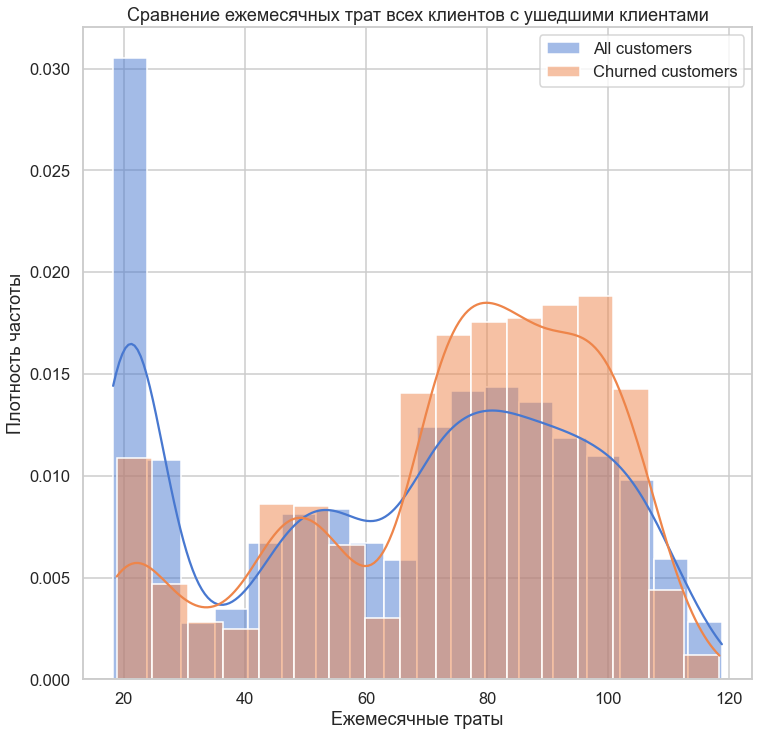

In [6]:
plt.figure(figsize=(12,12))

for i, df_name in enumerate(['all', 'exited']):
    if df_name == 'all':
        label = 'All customers'
    else:
        label = 'Churned customers'
        
    sns.histplot(
        df[df_name],
        x = 'MonthlyCharges',
        kde = True,
        stat = 'density', 
        label = label,
        color = sns.color_palette('muted')[i]
    )
    
plt.legend(title = '')      
plt.title('Сравнение ежемесячных трат всех клиентов с ушедшими клиентами')
plt.xlabel('Ежемесячные траты')
plt.ylabel('Плотность частоты')
plt.show()

В каждом случае наблюдается три пика. Возможно, это связано с тем, какими сервисами пользуются клиенты: телефоном, интернетом или и тем, и другим. Видно, что среди ушедших клиентов по сравнению с общей массой клиентов существенно больше тех, кто платит много (высокий третий пик) и меньше тех, кто платит мало (низкий первый пик). Если предположить, что пики соответствуют услугам, то, рапределение услуг среди ушедших клиентов также будет отличаться от общего: меньше пользователей только телефонии, больше пользователей всех услуг вместе - соответственно и выше стоимость тарифа.

Посмотрим на частотные гистограммы трат в зависимости от использованных услуг для ушедших клиентов и для всех клиентов вместе. 

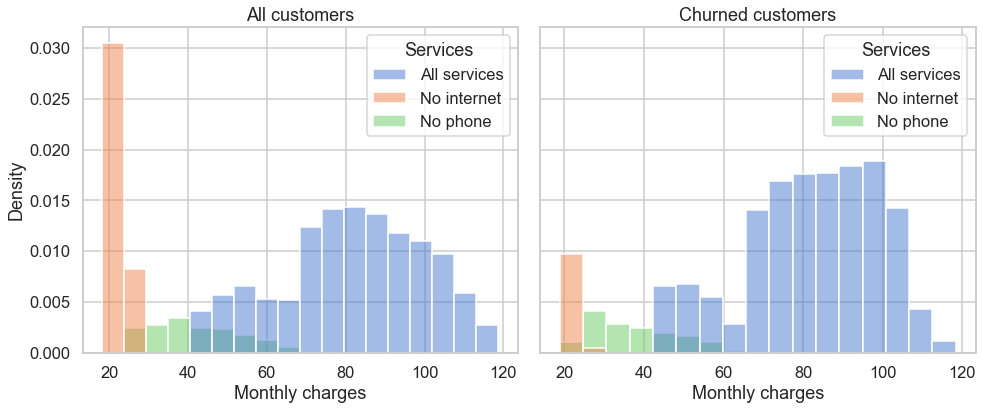

In [7]:
f, ax = plt.subplots(1, 2, sharey=True, gridspec_kw={'wspace': 0.05})
f.set_figheight(6)
f.set_figwidth(16)

for i, df_name in enumerate(['all', 'exited']):
    sns.histplot(
        df[df_name],
        x = 'MonthlyCharges',
        hue = 'Services',
        stat = 'density', 
        ax = ax[i]
    )
    ax[i].set(xlabel='Monthly charges', ylabel='Density')

ax[0].set_title('All customers')
ax[1].set_title('Churned customers')
plt.show()

Гистограммы показывают, что пики соответствуют разным типам услуг: видно, что клиенты, использующие только телефон, плаят мало, а клиенты, использующие все сервисы, - много. При этом у распределения клиентов со всеми сервисами также есть локальные максимумы - они могут соответствовать использованию дополнительных интернет-услуг и различиям в стоимости разного вида интернета: DSL и оптики. Два пика телефонии также соответствуют двум типам услуги: одна линия и многоканальная связь.

Среди ушедших клиентов больше пользователей интернета и больше тех, у кого высокая стоимость ежемесячного обслуживания. При этом пользователей только телефонии существенно меньше по сравнению с общими данными. 

Посмотрим, как распределены виды услуг среди пользователей.

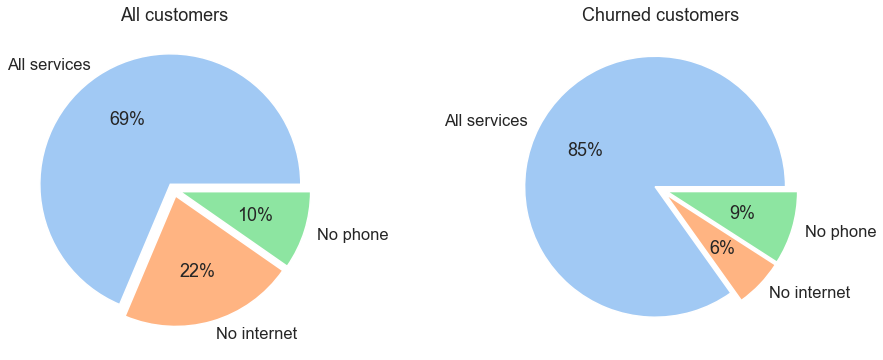

In [8]:
f, ax = plt.subplots(1, 2, gridspec_kw={'wspace': 0.2})
f.set_figheight(6)
f.set_figwidth(16)

for i, df_name in enumerate(['all', 'exited']):
    service_info = df[df_name]['Services'].value_counts().sort_index()
    ax[i].pie(
        service_info,
        labels = service_info.index,
        autopct = '%.0f%%',
        colors = sns.color_palette('pastel'),
        explode = (0.05, 0.05, 0.05)
    )

ax[0].set_title('All customers')
ax[1].set_title('Churned customers')
plt.show()

Если среди всех пользователей 22% не используют интернет, то среди ушедших клиентов без интернета было только 6%.

Оценим, могут ли быть эти различия случайными. Для этого с помощью критерия Хи-квадрат Пирсона сравним наблюдаемые и ожидаемые распределения количества клиентов с тем или иным типом услуг для выборок ушедших и оставшихся клиентов.

In [9]:
service_info = (
    (df['exited']['Services'].value_counts().to_frame(name='Exited'))
    .join(df['stayed']['Services'].value_counts().to_frame(name='Stayed'))
)
service_info

,Exited,Stayed
All services,1586,3249
No phone,170,512
No internet,113,1413


Сравним полученную таблицу реальных значений с таблицей ожидаемых значений для случая, когда распределение услуг не зависит от того, ушёл клиент или остался.

In [10]:
chi2, p_value, ddof, expected = st.chi2_contingency(service_info)

pd.DataFrame(expected, columns=service_info.columns, index=service_info.index).astype('int')

,Exited,Stayed
All services,1283,3551
No phone,180,501
No internet,404,1121


Видно, что в таблице ожидаемых значений количество пользователей одной телефонии, без интернета, существенно больше, чем реально наблюдаемое количество. Является ли эта разница статистически значимой? Сформулируем нулевую гипотезу: распрелеление устуг среди ушедших клиентов и среди оставшихся одинаково. Альтернативная гипотеза: соотношение пользователей интернета и телефонии у ушедших клиентов отличается от оставшихся. Уровень значимости установим равным 1% и посчитаем, какова вероятность получить такое или ещё более выраженное различие в данных.

In [11]:
alpha = 0.01

if p_value < alpha:
    print('Нулевая гипотеза опровергнута.')
    print('Соотношение пользователей интернета и телефонии у ушедших клиентов и у оставшихся отличается.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 
    print('p-value = {:.2%}'.format(p_value))

Нулевая гипотеза опровергнута.
Соотношение пользователей интернета и телефонии у ушедших клиентов и у оставшихся отличается.


Различия оказались значимыми. С помощью t-теста Стьюдента сравним также средние значения ежемесячных трат пользователей. Распределения отклоняются от нормальных, но нет больших выбросов, которые сильно тянули бы значение среднего в сторону от медианы, поэтому можно использовать параметрический критерий. Нулевая гипотеза: средние значения ежемесячных трат ушедших клиентов и оставшихся не отличаются. Альтернативная гипотеза: ушедшие клиенты платят в среднем больше. Выше было показано, что среднее значение в выборке ушедших клиентов выше, чем среднее оставшихся и общее среднее. Посмотрим, какова вероятность получить такие и более значимые различия. Если меньше 1%, то отвергаем нулевую гипотезу.

In [12]:
p_value = st.ttest_ind(
    df['exited']['MonthlyCharges'],
    df['stayed']['MonthlyCharges'],
    equal_var=False
).pvalue / 2 #Делим на 2, потому что односторонняя гипотеза

if p_value < alpha:
    print('Нулевая гипотеза опровергнута.')
    print('Средние ежемесячные траты ушедших пользователей больше оставшихся.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 
    print('p-value = {:.2%}'.format(p_value))

Нулевая гипотеза опровергнута.
Средние ежемесячные траты ушедших пользователей больше оставшихся.


**Вывод**

Данные были загружены и разделены на три выборки: все клиенты, ушедшие клиенты, оставшиеся клиенты. Была проанализирована информация о ежемесячных тратах клиентов и об услугах, которыми они пользуются: интернет, телефон или и то, и другое.

Анализ показал следующее:
- ушедшие клиенты платят в среднем больше
- среди ушедших клиентов больше пользователей интернета

Найденные отличия статистически значимы: проведён t-тест для сравнения средних значений трат и хи-квадрат - для сравнения распределения используемых услуг.